Data loaded successfully. Shape: (400, 3)
Outlier filtering: Removed 74 points (18.5%)
Original current range: 2.090000e-03 to 7.158640e+00
Filtered current range: 2.090000e-03 to 1.844800e-02
Plot saved as: I-Vx-Vp_m0x3Vn_0Vs_MUXon_50MHz0dBm_2509251107_filtered_plot.pdf


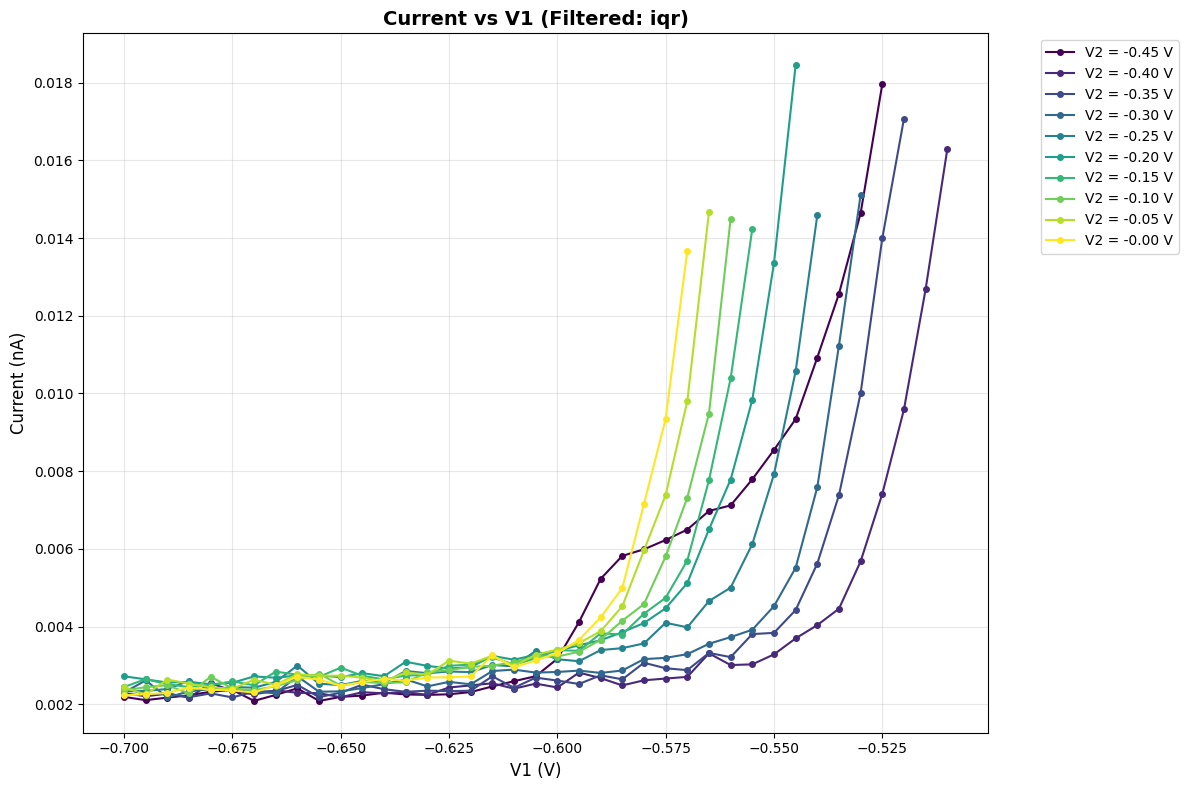

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy import stats
import warnings
warnings.filterwarnings('ignore')



def filter_outliers(data, method='iqr', z_threshold=3, iqr_factor=1.5, percentile_range=(5, 95)):
    """
    Filter outliers from the data using various methods.
    
    Parameters:
    -----------
    data : array-like
        The data to filter (typically the current values)
    method : str
        Method for outlier detection: 'iqr', 'zscore', 'percentile', or 'none'
    z_threshold : float
        Z-score threshold for zscore method (default: 3)
    iqr_factor : float
        IQR multiplier for IQR method (default: 1.5)
    percentile_range : tuple
        (lower, upper) percentiles for percentile method
    
    Returns:
    --------
    mask : boolean array
        True for inliers, False for outliers
    """
    if method == 'none':
        return np.ones(len(data), dtype=bool)
    
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(data))
        return z_scores < z_threshold
    
    elif method == 'iqr':
        Q1 = np.percentile(data, 0)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_factor * IQR
        upper_bound = Q3 + iqr_factor * IQR
        return (data >= lower_bound) & (data <= upper_bound)
    
    elif method == 'percentile':
        lower = np.percentile(data, percentile_range[0])
        upper = np.percentile(data, percentile_range[1])
        return (data >= lower) & (data <= upper)
    
    else:
        raise ValueError(f"Unknown method: {method}")

def plot_voltage_sweep_data_filtered(filename='I-Vx-Vp_m0x3Vn_0Vs_MUXon_50MHz0dBm_2509251107.txt', 
                                    save_pdf=True, 
                                    pdf_filename=None,
                                    outlier_method='iqr',
                                    current_range=None,
                                    **outlier_kwargs):
    """
    Plot current vs V1 curves with outlier filtering.
    
    Parameters:
    -----------
    filename : str
        Path to the data file
    save_pdf : bool
        Whether to save the plot as PDF
    pdf_filename : str
        Name of the PDF file
    outlier_method : str
        Method for outlier detection: 'iqr', 'zscore', 'percentile', or 'none'
    current_range : tuple or None
        (min, max) current values to display
    **outlier_kwargs : dict
        Additional arguments for outlier filtering
    """
    
    # Read the data from file
    try:
        data = np.loadtxt(filename)
        print(f"Data loaded successfully. Shape: {data.shape}")
    except Exception as e:
        print(f"Error reading file: {e}")
        return
    
    # Extract columns
    V2_values = data[:, 0]
    V1_values = data[:, 1]  
    currents = data[:, 2]
    
    # Apply outlier filtering
    outlier_mask = filter_outliers(currents, method=outlier_method, **outlier_kwargs)
    
    # Apply current range if specified
    if current_range is not None:
        range_mask = apply_current_range(currents, current_range[0], current_range[1])
        final_mask = outlier_mask & range_mask
    else:
        final_mask = outlier_mask
    
    # Filter the data
    V2_filtered = V2_values[final_mask]
    V1_filtered = V1_values[final_mask]
    currents_filtered = currents[final_mask]
    
    # Print filtering statistics
    n_removed = len(currents) - len(currents_filtered)
    print(f"Outlier filtering: Removed {n_removed} points ({100*n_removed/len(currents):.1f}%)")
    print(f"Original current range: {currents.min():.6e} to {currents.max():.6e}")
    print(f"Filtered current range: {currents_filtered.min():.6e} to {currents_filtered.max():.6e}")
    
    # Group data by V2 values
    data_by_V2 = defaultdict(lambda: {'V1': [], 'current': []})
    
    for v2, v1, current in zip(V2_filtered, V1_filtered, currents_filtered):
        data_by_V2[v2]['V1'].append(v1)
        data_by_V2[v2]['current'].append(current)
    
    # Sort V2 keys for consistent plotting
    sorted_V2_keys = sorted(data_by_V2.keys())
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot each V2 curve
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_V2_keys)))
    
    for i, v2 in enumerate(sorted_V2_keys):
        V1_sorted = np.array(data_by_V2[v2]['V1'])
        current_sorted = np.array(data_by_V2[v2]['current'])
        
        # Sort by V1 to ensure proper line plotting
        sort_indices = np.argsort(V1_sorted)
        V1_sorted = V1_sorted[sort_indices]
        current_sorted = current_sorted[sort_indices]
        
        plt.plot(V1_sorted, current_sorted, '-o', 
                color=colors[i], 
                label=f'V2 = {v2:.2f} V',
                markersize=4,
                linewidth=1.5)
    
    # Formatting
    plt.xlabel('V1 (V)', fontsize=12)
    plt.ylabel('Current (nA)', fontsize=12)
    title = f'Current vs V1 (Filtered: {outlier_method})'
    if current_range:
        title += f'\nCurrent range: [{current_range[0]:.2e}, {current_range[1]:.2e}]'
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Save as PDF if requested
    if save_pdf:
        if pdf_filename is None:
            base_name = filename.replace('.txt', '').replace('.dat', '')
            pdf_filename = f"{base_name}_filtered_plot.pdf"
        
        plt.savefig(pdf_filename, format='pdf', dpi=300, bbox_inches='tight')
        print(f"Plot saved as: {pdf_filename}")
    
    plt.show()
    
    return data_by_V2


if __name__ == "__main__":

    filename = 'I-Vx-Vp_m0x3Vn_0Vs_MUXon_50MHz0dBm_2509251107.txt'
    


#plot iv
    plot_voltage_sweep_data_filtered(
        filename,
        #outlier_method='iqr',
        #iqr_factor=1.5,
        save_pdf=True
    )